In [1]:
import sys, os, time, glob
import numpy as np
from datetime import datetime
from statistics import median
import matplotlib.pyplot as plt
# import statsmodels.api as sm
import csv
from csv import writer
from csv import reader
import pandas as pd 

In [6]:
dir_name = '/lcrc/project/EE-ECP/jkoo/code/sdv/Benchmarks/'
kernel_dir = 'covariance_void'
kernel = 'covariance'
# kernel_dir = 'heat-3d_void'
# kernel = 'heat-3d'

d_sizes = ['s','sm','m','ml','l','xl']
o3p = {}
for s in d_sizes: 
    time = pd.read_csv(f'{dir_name}{kernel}_exp/{kernel_dir}/results_{s}_{kernel}_void.csv')['objective']
    o3p[s] = float(time)
print (o3p)    

{'s': 0.000732, 'sm': 0.0051485, 'm': 0.016036, 'ml': 0.460138, 'l': 2.157349, 'xl': 21.8962815}


In [7]:
#### RF rerun 
dir_name = '/lcrc/project/EE-ECP/jkoo/code/ytopt/ytopt/benchmark/polybench-exp'
dir_name_gptune = '/lcrc/project/EE-ECP/jkoo/code/gptune/examples'
N_infer = 30 # len(200)
n = N_infer
# plot something

d_sizes = ['sm','ml','xl']
gathered = []
cutoffs = []

gathered = [] 
cutoffs = [] 
tag1 = ''#_1.96_gp'# '_1.96_lcb'# 
tag2 = '' # '_19.6_lcb'#_1.96_gp_n30'# '_11.0_lcb' # 
tag3 = ''
tag4 = ''#_1.96_gp'# '_1.96_lcb'# 
tag5 = ''#_1.96_gp_n30'# '_11.0_lcb' # 

for d_size, o3 in zip(d_sizes, o3p):   
    
    alpha = 0.1
    t = 0
    evals = []    
    
    ### BO
    file_n = f'{dir_name}/{kernel}/results_rf_{d_size}_{kernel}{tag1}.csv'
    evals_bo = o3p[d_size] / np.array(pd.read_csv(file_n)['objective']) 
    T_bo  = np.array(pd.read_csv(file_n)['elapsed_sec'])
    evals.extend(evals_bo)
    counter_bo = 0 
    plot_bo = [0]
    best_bo = 0.
    idx_bo = 0
    t_bo = T_bo[idx_bo] 

    ## RS 
    file_n = f'{dir_name}/{kernel}/results_rs_{d_size}_{kernel}{tag1}.csv'
    evals_rs = o3p[d_size] / np.array(pd.read_csv(file_n)['objective']) 
    T_rs  = np.array(pd.read_csv(file_n)['elapsed_sec'])
    evals.extend(evals_rs)
    counter_rs = 0
    plot_rs = [0]
    best_rs = 0. 
    idx_rs = 0
    t_rs = T_rs[idx_rs]
        
    ## GPTUNE 
    file_n = f'{dir_name_gptune}/{kernel}_exp/{kernel}_gptune_dtla/TLA_experiments/SLA-GPTune-{d_size}-tl/results.csv'
    evals_dtla = o3p[d_size] / np.array(pd.read_csv(file_n)['objective']) 
    T_dtla  = np.array(pd.read_csv(file_n)['elapsed_sec'])    
    evals.extend(evals_dtla)
    counter_dtla = 0
    plot_dtla = [0]
    best_dtla = 0.
    idx_dtla = 0
    t_dtla = T_dtla[idx_dtla]
    
    ## SDV
    file_n = f'{dir_name}/{kernel}/results_sdv_{d_size}_{kernel}{tag1}.csv'
    evals_sdv = o3p[d_size] / np.array(pd.read_csv(file_n)['exe_time']) 
    T_sdv = np.array(pd.read_csv(file_n)['elapsed_sec'])  
    evals.extend(evals_sdv)
    counter_sdv = 0 
    plot_sdv = [0] 
    best_sdv = 0.
    idx_sdv = 0         
    t_sdv = T_sdv[idx_sdv]
    
#     ## SDV ITR
#     evals_sdv_itr = o3 / np.array(pd.read_csv('./'+kernel_dir+'/results_rf_' +d_size + '_'+kernel+tag5+'.csv')['objective'])
#     T_sdv_itr = np.array(pd.read_csv('./'+kernel_dir+'/results_rf_' +d_size + '_'+kernel+tag5+'.csv')['elapsed_sec'])
#     evals.extend(evals_sdv_itr)
#     counter_sdv_itr = 0 
#     plot_sdv_itr = [0] 
#     best_sdv_itr = 0. 
#     idx_sdv_itr = 0
#     t_sdv_itr = T_sdv_itr[idx_sdv_itr]
     
    cutoff = sorted(evals, reverse=True)[int(len(evals)*alpha)]#[0]
    print ('cutoff', cutoff)    
        
#     T_max = int(max(T_bo.max(), T_rs.max(), T_dtla.max(), T_sdv.max(), T_sdv_itr.max()))     
    T_max = int(max(T_bo.max(), T_rs.max(), T_dtla.max())) 
    while t < T_max:  
        # bo
        if t_bo < t and idx_bo <= N_infer-1:
            bo_tmp = float(evals_bo[idx_bo])   
            if bo_tmp > best_bo:
                best_bo =  bo_tmp
            plot_bo.append(best_bo)
            idx_bo += 1 
            if idx_bo <= N_infer-1:
                t_bo = T_bo[idx_bo]
        elif idx_bo == N_infer:
            pass
        else:
            plot_bo.append(best_bo)
            
        # rs  
        if t_rs < t and idx_rs <= N_infer-1: 
            rs_tmp = float(evals_rs[idx_rs])    
            if rs_tmp > best_rs:
                best_rs =  rs_tmp 
            plot_rs.append(best_rs)
            idx_rs += 1 
            if idx_rs <= N_infer-1:
                t_rs = T_rs[idx_rs]
        elif idx_rs == N_infer:
            pass
        else:
            plot_rs.append(best_rs)

          # gptune 
        if t_dtla < t and idx_dtla <= N_infer-1:
            dtla_tmp_itr = float(evals_dtla[idx_dtla])
            if dtla_tmp_itr > best_dtla:
                best_dtla =  dtla_tmp_itr 
            plot_dtla.append(best_dtla)
            idx_dtla += 1 
            if idx_dtla <= N_infer-1:
                t_dtla = T_dtla[idx_dtla]    
        elif idx_dtla == N_infer:
            pass
        else:
            plot_dtla.append(best_dtla)              
            
        # sdv 
        if t_sdv < t and idx_sdv <= N_infer-1:
            sdv_tmp = float(evals_sdv[idx_sdv])
            if sdv_tmp > best_sdv:
                best_sdv =  sdv_tmp 
            plot_sdv.append(best_sdv)
            idx_sdv += 1 
            if idx_sdv <= 29:
                t_sdv = T_sdv[idx_sdv]    
        elif idx_sdv == N_infer:
            pass
        else:
            plot_sdv.append(best_sdv)          

#          # sdv itr 
#         if t_sdv_itr < t and idx_sdv_itr <= N_infer-1:
#             sdv_tmp_itr = float(evals_sdv_itr[idx_sdv_itr])
#             if sdv_tmp_itr > best_sdv_itr:
#                 best_sdv_itr =  sdv_tmp_itr 
#             plot_sdv_itr.append(best_sdv_itr)
#             idx_sdv_itr += 1 
#             if idx_sdv_itr <= 199:
#                 t_sdv_itr = T_sdv_itr[idx_sdv_itr]    
#         elif idx_sdv_itr == N_infer:
#             pass
#         else:
#             plot_sdv_itr.append(best_sdv_itr)                   
        t += 1     
            
    cc = {}
    cc['bo'] = plot_bo
    cc['rs'] = plot_rs
    cc['dtla'] = plot_dtla
    
#     cc['kde'] = plot_kde
    cc['sdv'] = plot_sdv 
#     cc['sdv_30'] = plot_sdv_30
#     cc['sdv_50'] = plot_sdv_50
#     cc['sdv_itr'] = plot_sdv_itr

    gathered.append(cc)
#     cutoffs.append(cutoff)

cutoff 13.133928571428573
cutoff 2.217361552844118
cutoff 13.803315060272105


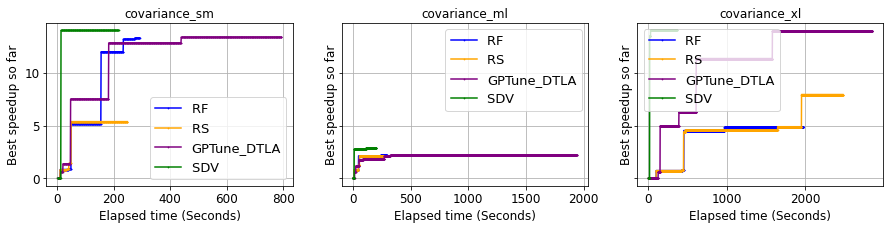

In [11]:
fig, axs = plt.subplots(1,3, figsize=(15, 3), sharex=False, sharey=True)
BEST = []
for ax, cc, d_size in zip(axs.flat,gathered,d_sizes):
# for cc in gathered:
#     ax.scatter(*np.random.normal(size=(2,200)))
#     ax.set_title(kernel+d_size,fontsize=14)
    dict_s = cc
    #     dict_s['-O3 Polly'] = [0] *1000
    for k, v in dict_s.items():
        if k == 'bo':
            k = 'RF ' + tag1 
#             k = 'RF lcb 1.96 n1'
            color = 'blue'
        if k == 'rs':
            k = 'RS ' + tag2 
#             k = 'RF lcb 11.0 n1'
            color = 'orange'
        if k == 'dtla':
            k = 'GPTune_DTLA'
            color = 'purple'    
        if k == 'sdv':
            k = 'SDV ' + tag3
            color = 'green'
#         if k == 'sdv_30':
#             k = 'SDV_30'
#             color = 'red'
#         if k == 'sdv_50':
#             k = 'SDV_50'
#             color = 'purple'
#         if k == 'sdv_itr':
#             k = 'RF ' + tag4
#             color = 'green'
#         print (d_size, k, v[-1])
        BEST.append(v[-1])
        ax.plot(range(1, len(v) + 1), v, '.-', label=k,linewidth=1.5,markersize=1.5,color=color)
        # NOTE: changed `range(1, 4)` to mach actual values count
    ax.legend(fontsize=13)#,loc='center right')  # To draw legend
    #     plt.title(k_name[:-1],fontsize=14)
    # plt.xlim(0,max_exp+10)
    #     plt.ylim(bottom=0.5)
    ax.set_ylabel('Best speedup so far', fontsize=12)
    ax.set_xlabel('Elapsed time (Seconds)', fontsize=12)
    ax.set_title(kernel+'_'+d_size,fontsize=12)
    ax.tick_params(axis="x", labelsize=12) 
    ax.tick_params(axis="y", labelsize=12) 
#     ax.set_xticklabels(fontsize=14)
#     ax.set_yticklabels(fontsize=14)
    ax.grid()
#     plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8))

# set height of bar
###### S   M   L
'''
1.506179
7.544698
30.0485
'''


bb  = BEST
RF  = [bb[0], bb[3],bb[6]]#, 0, 0]
RS  = [bb[1], bb[4], bb[7]]#, 0, 0]
GPT = [bb[2], bb[5], bb[8]] #, 0, 0]

o3p = [1.078895,2.270945,6.515330000]

# TLA1 = [1.506179/0.163,7.544698 /0.8192, 30.0485/3.2781]

TLA1 = [o3p[0]/0.8985,o3p[1]/1.8721, o3p[2]/4.8765]

# Set position of bar on Xaxis
br1 = np.arange(len(RF))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, RF, color ='blue', width = barWidth,
		edgecolor ='grey', label ='RF')
plt.bar(br2, RS, color ='red', width = barWidth,
		edgecolor ='grey', label ='GC no refit')
plt.bar(br3, GPT, color ='pink', width = barWidth,
		edgecolor ='grey', label ='GC refit')
plt.bar(br4, TLA1, color ='purple', width = barWidth,
		edgecolor ='grey', label ='GPTune TLA1')

# Adding Xticks
plt.xlabel('Input size', fontweight ='bold', fontsize = 12)
plt.ylabel('Best speedup', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(RF))],
		['SM', 'ML', 'XL'])#, '', ''])
plt.title('Target sizes: '+kernel_dir, fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()


In [ ]:
import sys, os, time, glob
import numpy as np
from datetime import datetime
from statistics import median
import matplotlib.pyplot as plt
import statsmodels.api as sm
import csv
from csv import writer
from csv import reader
import pandas as pd 

In [ ]:
d_sizes = ['sm']#,'ml','xl']
idx_start = [24,33,42]
gathered = [] 
cutoffs = [] 
what = 'exe_time'
for d_size, i_start in zip(d_sizes,idx_start):
#     T_bo  = np.array(pd.read_csv('./xsbench/results_rf_' +d_size + '_xsbench.csv')[what])
#     T_rs  = np.array(pd.read_csv('./xsbench/results_rs_' +d_size + '_xsbench.csv')[what])
#     T_kde = np.array(pd.read_csv('./xsbench/results_kde_' +d_size + '_xsbench.csv')[what])
    T_sdv = np.array(pd.read_csv('./xsbench/results_sdv_' +d_size + '_xsbench.csv')[what])
    plt.plot(T_sdv)
    m = T_sdv.mean()
    s = T_sdv.std()
#     plt.ylim((T_sdv.min(),m+s))
    ss = 0.0005
    plt.ylim((T_sdv.min()-ss,m+ss))
    plt.title()
    plt.xlabel()
    plt.ylabel('Execution time')
    plt.show()

In [ ]:
tt = [
    0.444345, 
    0.4481, 
    0.45314, 
    0.510685, 
    0.565134999, 
    1.042415, 
    1.622645, 
    6.5066349, 
    12.19831, 
    23.72206, 
    24.83412] 

In [ ]:
input_sizes = {}
input_sizes['s1']  = [100000]
input_sizes['s2']  = [500000]
input_sizes['s3']  = [1000000]
input_sizes['s4']  = [5000000]
input_sizes['s5']  = [10000000]
input_sizes['s6']  = [50000000]
input_sizes['s7']  = [100000000]
input_sizes['s8']  = [500000000]
input_sizes['s9']  = [1000000000]
input_sizes['s10'] = [2000000000]
input_sizes['s11'] = [2100000000]

In [ ]:
ss = []
for key in input_sizes.keys():
    print (key)
    ss.append(input_sizes[key][0])

In [ ]:
ss

In [ ]:
plt.scatter(ss,tt)

In [ ]:
for t in ss:
    print (t)

In [ ]:
class Solution(object):
    def mySqrt(self, x):
        """
        :type x: int
        :rtype: int
        """
#         if x == 0:
#             return 0
#         if x <= 3:
#             return 1 
        
#         stop = False 
#         count = 2 
#         while stop == False:
            
#             compare = count * count
#             if x == compare:
#                 return count
#             if x < compare:
#                 return count -1
            
#             count += 1 
        
        ### binar search 
        l, r = 0, x
        while l <= r:
            mid = l + (r-l)//2
            if mid * mid <= x < (mid+1)*(mid+1):
                return mid
            elif x < mid * mid:
                r = mid - 1
            else:
                l = mid + 1  

In [ ]:
ss = Solution

In [ ]:
ss.mySqrt(self=None,x=5)

In [ ]:
7*9*2*2*9*9*3*6

In [ ]:
a = {}

In [ ]:
a[1] = 2

In [ ]:
a[2] = 3

In [ ]:
nums = [1,2,2,2]
dic = {}
for num in nums:
#     print (num,dic.get(num, 0))
    dic[num] = dic.get(num, '0')+'1'
#     print (num,dic[num])
print (dic)    

In [ ]:
dic.get(2,6)

In [ ]:
dic

In [ ]:
dic

In [ ]:
dic.get(2, 1)+1

In [ ]:
car = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

x = car.get("model",1)



In [ ]:
print(x)

In [ ]:
car